1. Read the Rules!
2. Construct a ReLU-activated neural network with four hidden layers with sizes [1000, 1000,
500, 200]. Note: you’ll have a fifth layer for your output logits, which you will have 10 of.
3. Train your network on MNIST or Fashion-MNIST (your choice, whatever is easier)
4. Prune away (set to zero) the k% of weights using weight and unit pruning for k in [0, 25,
50, 60, 70, 80, 90, 95, 97, 99]. Remember not to prune the weights leading to the output
logits.
5. Create a table or plot showing the percent sparsity (number of weights in your network
that are zero) versus percent accuracy with two curves (one for weight pruning and one
for unit pruning).
6. Make your code clean and readable. Add comments where needed.
7. Follow the submission guidelines 

Bonus: See if you can find a way to use your new-found sparsity to speed up the execution of
your neural net! Hint: ctrl + f “sparse” in the TF docs, or use unit level sparsity (which deletes
entire rows and columns from weight matrices). This can be tricky but is a worthwhile engineering
lesson in the optimization of Tensorflow / PyTorch models. Report the increased speed. For
example: the performance improved by 25% after using this. 

In [1]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import sys
from tensorflow.examples.tutorials import mnist

In [2]:
data=mnist.input_data.read_data_sets("./Neural networks/",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./Neural networks/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./Neural networks/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./Neural networks/t10k-images-idx3-ubyte.gz
Extracting ./Neural networks/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.



# Deep Model

In [3]:
tf.reset_default_graph()
X=tf.placeholder("float32",shape=(None,784),name="input_x")
Y=tf.placeholder("int32",shape=(None,10),name="labels")

In [4]:
weights={
    "L1": tf.Variable(tf.random_uniform((784,1000))),
    "L2": tf.Variable(tf.random_uniform((1000,1000))),
    "L3": tf.Variable(tf.random_uniform((1000,500))),
    "L4": tf.Variable(tf.random_uniform((500,200))),
    "output": tf.Variable(tf.random_uniform((1000,10))),
}

In [5]:
def forward(X):
    l1=tf.nn.relu(tf.matmul(X,weights["L1"]))
    l2=tf.nn.relu(tf.matmul(l1,weights["L2"]))
    l3=tf.nn.relu(tf.matmul(l2,weights["L3"]))
    l4=tf.nn.relu(tf.matmul(l3,weights["L4"]))
    output=tf.matmul(l2,weights["output"])
    
    return output
    

In [6]:
preds=forward(X)
loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y,logits=preds))

opti=tf.train.AdamOptimizer(learning_rate=0.01)
step=opti.minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



# Training

In [7]:
def train_model(Sess):
    batch_size = 100
    for i in range(3):
        num_batches = int(data.train.num_examples/batch_size)
        total_cost = 0

        for j in range(num_batches):
            batch_x, batch_y = data.train.next_batch(batch_size) 
            c, _ = Sess.run([loss, step], feed_dict={X:batch_x, Y:batch_y})
            total_cost += c

        print(total_cost)

# Pruning

#### Session1 and training 

In [8]:
Sess1=tf.Session()     #Session1
Sess1.run(tf.global_variables_initializer())

train_model(Sess1)
 
pred=Sess1.run([preds],feed_dict={X:data.test.images /255.})
(pred[0].argmax(1)==data.test.labels.argmax(1)).sum()/ pred[0].shape[0]  #accuracy

15023579.8861866
23877.560679078102
6335.2667660141


0.9354

### Weight Pruning 

Weight pruning: set individual weights in the weight matrix to zero. This corresponds to deleting connections as in the figure above.

Here, to achieve sparsity of k% we rank the individual weights in weight matrix W according to their magnitude (absolute value), and then set to zero the smallest k%.

Pruning the weights of the layers L2


In [10]:
acc_w=[]
k=[0,25,50,60,70,80,90,95,97,99]

for i in k:
    wts=Sess1.run(weights)["L2"].reshape((-1,))
                              
    param=10000*i  #there are 1000000 parameters weights total in layers l2,l3,l4
    idx = np.argpartition(wts, param)
    wts[idx[:param]]=0.0 #etting i% params to 0
    Sess1.run(tf.assign(weights["L2"],tf.convert_to_tensor(wts[:1000000].reshape(1000,1000)))) 
   
    pred=Sess1.run([preds],feed_dict={X:data.test.images /255.})
    acc_w.append((pred[0].argmax(1)==data.test.labels.argmax(1)).sum()/ pred[0].shape[0] * 100)
    

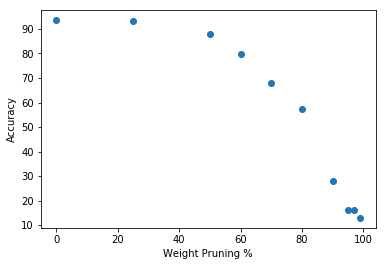

In [11]:
plt.scatter(k,acc_w)
plt.ylabel("Accuracy")
plt.xlabel("Weight Pruning %")
plt.show()

## Neuron Pruning

set entire columns to zero in the weight matrix to zero, in effect
deleting the corresponding output neuron.

Here to achieve sparsity of k% we rank the columns of a weight matrix according
to their L2-norm and delete the smallest k%.


#### Session2 and training 

In [13]:
Sess2=tf.Session()     #Session2
Sess2.run(tf.global_variables_initializer())

train_model(Sess2)
 
pred=Sess2.run([preds],feed_dict={X:data.test.images /255.})
(pred[0].argmax(1)==data.test.labels.argmax(1)).sum()/ pred[0].shape[0]  #accuracy

15043344.059488177
4213.803618602455
1731.5252162141355


0.9364

Pruning the neurons of L2 layer

In [14]:
def unit_prun(Lay):
    
    acc=[]
    k=[0,25,50,60,70,80,90,95,97,99]
    arbit=Sess2.run(weights)[Lay]
    for i in k:
        wts=Sess2.run(weights)[Lay]
        l2_norm=(wts**2).sum(axis=0)
        param=int(arbit.shape[1]*i /100)
        
        idx = np.argpartition(l2_norm, param)

        wts[:,idx[:param]]=0    # setting i% of units with low L2 norm to Zero
        
#         wts=tf.convert_to_tensor(wts)
#         zero = tf.constant(0, dtype=tf.float32)
#         where = tf.not_equal(wts, zero)
#         indices = tf.where(where)
#         values = tf.gather_nd(wts, indices)
#         wts = tf.SparseTensor(indices, values, wts.shape)
        
        Sess2.run(tf.assign(weights[Lay],tf.convert_to_tensor(wts)))  # assigning


        pred=Sess2.run([preds],feed_dict={X:data.test.images /255.})

        acc.append((pred[0].argmax(1)==data.test.labels.argmax(1)).sum()/ pred[0].shape[0] * 100)
        
    return k,acc


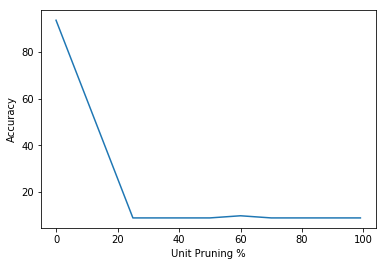

In [15]:
k,acc_u=unit_prun("L2")
plt.plot(k,acc_u)
plt.ylabel("Accuracy")
plt.xlabel("Unit Pruning %")
plt.show()

# Comparing and conclusion 

Text(0,0.5,'Accuracy')

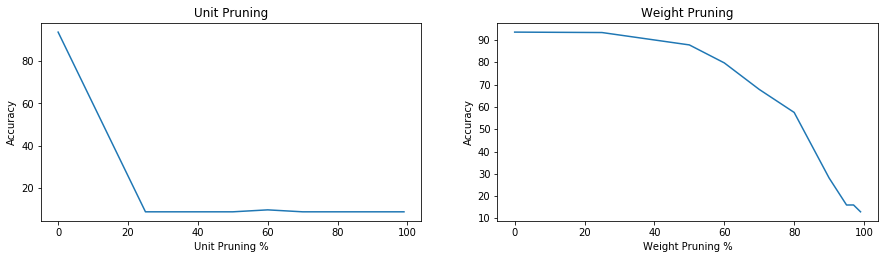

In [21]:
fig=plt.figure(figsize=(15,8))

ax1=fig.add_subplot(2,2,2)
ax1.plot(k,acc_w)
ax1.set_title("Weight Pruning")
ax1.set_xlabel("Weight Pruning %")
ax1.set_ylabel("Accuracy")

ax2=fig.add_subplot(2,2,1)
ax2.plot(k,acc_u)
ax2.set_title("Unit Pruning")
ax2.set_xlabel("Unit Pruning %")
ax2.set_ylabel("Accuracy") 


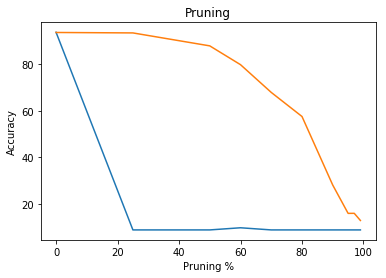

In [22]:
plt.plot(k,acc_u)
plt.plot(k,acc_w)
plt.xlabel("Pruning %")
plt.ylabel("Accuracy")
plt.title("Pruning")
plt.show()

# CONCLUSION 

### * Weight Pruning Tends to work better for the layer L2 , there's a parabolic decrease in accuracy.


### * Unit pruning for L2 only works as expected and decreases linearly and then steeply with the accuracy of the model


